# Honey Bee Roundup

### Technical Goals:

Our technical goals are to analyze honeybee colony data from the USDA to determine if there is a statistically significant amount of loss among colonies over time, and to develop a machine learning model that accurately predicts honeybee colony loss based on significant environmental and human-driven features. We can use these predictions to make recommendations to stakeholders to minimize colony loss and improve outcomes.

### Business Goals:

Honeybees pollinate 15 billion worth of crops in the United States each year, including more than 130 types of fruits, nuts, and vegetables. Honeybees also produce honey, worth about 3.2 million in 2017 according to USDA-National Agricultural Statistics Service (NASS).

We want to provide stakeholders with an accurate model for predicting colony loss over time, which factors affect colony loss, and which areas are most conducive to colony production and preservation. We also want to provide a way for stakeholders to test outcomes based on actions they take (or not take) to mitigate colony loss. Our overarching business goal is to influence stakeholders to make responsible and proactive decisions to help honeybees thrive.

### Hypothesis

Our initial hypothesis is that honeybee colony loss has increased over time and will continue to increase year over year if no measures are taken to mitigate or reverse this outcome. Some initial questions we have are:

How much have honeybee colonies diminished over time? Is this loss compounded year over year?

What significant features drive honeybee colony loss?

What time of year is the biggest loss?

What state/area suffers heaviest loss and primary factors attributing to that?

Does summer or winter have the largest loss?

Does the beekeeper to colony ratio have an effect on colony loss?

### Executive Summary

We trained and evaluated four linear regression models using five significant features affecting colony loss. The OLS model and the LassoLars model both performed very well, beating the baseline RMSE for colony loss by {} percent. We selected the Lasso Lars model as our best model. The model's RMSE for the test set was {}. We used this model both with randomized data and chronological data, and the model performed similarly for both sets. We recommend that states use this model to predict colony losses for the upcoming year, and to lower their beekeeper to colony ratio for significant improvements. They can use this model to see how their losses will be mitigated if they increase the number of beekeepers and/or modify their beekeeping operations based on the season.

In [2]:
# standard and user-defined functions imports
import pandas as pd
import numpy as np
import wrangle
import explore
import regression_models as model
import os

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# stats and modeling imports
from scipy import stats
from math import sqrt
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,explained_variance_score, r2_score
from sklearn.linear_model import LinearRegression,LassoLars,TweedieRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression

# remove warnings
import warnings
warnings.filterwarnings("ignore")
sns.set_theme()

## Acquisition

Data was originally found on Data.World, and further traced back to it's source to pull the most up-to-date data on Bees.

Of the original 3 Data sets:

- After assessement Census Data from the USDA was deemed not to have pertinent information to the current population of bees or health of hives, as well as the fact that it is reported in 5 year gaps, was removed from our initial data set.

- Survey Data by State from the USDA was also deemed as having less pertinent information on the trend in population of bees or health of their hives, and was left for further exploration as time permits due to a small amount of data on the environmental area of the colonies.

- The Bee Colony Loss Data from BeeInformed.org has the most relevant data regarding current number of colonies, number of bee keepers, and loss of bees and colonies, so was the data set we initially focused on. However, due to this privacy stipulation "For the protection of privacy, losses are reported as N/A if 10 or fewer beekeepers responded in that state. These beekeepers' losses are included in the national statistics." we decided to drop all records where the number of beekeepers were 10 or less, as most of the data was Null, and therefore not contributing towards our goal.

## Preparation

- We created separate functions for preparing the data- one for time series analysis and one for linear regression modeling. 
- All observations with 10 or less beekeepers were dropped because the data for those observations is protected under privacy laws. 
- All strings were stripped, lowercased, and spaces were replaced with underscores. 
- We engineered two columns: beekeeper_colony_ratio and colony_net_gain. 
- We also created dummy variables for the three categories in the season column: winter, summer, and annual.
- Multistate and non_continental data was dropped, and we isolated only observations with beekeepers exclusive to their respective states.

In [3]:
# acquire time series dataframe using function from wrangle.py and save to a variable
ts_df = wrangle.ts_bee_prep()

In [4]:
# confirm acquisition
ts_df.head()

,state,year,season,beekeepers,total_loss,average_loss,starting_colonies,colonies_lost,ending_colonies,beekeepers_exclusive_to_state,colonies_exclusive_to_state,annual,summer,winter,colonies_net_gain,beekeeper_colony_ratio
104,alabama,2008-10-01,winter,16,41.916168,29.610216,4848,2240,3104,100.0,100.0,0,0,1,-1744,194.000000
107,arkansas,2008-10-01,winter,20,17.449588,12.786836,16955,3046,14410,100.0,100.0,0,0,1,-2545,720.500000
114,georgia,2008-10-01,winter,15,34.481800,29.086689,42876,18605,35351,100.0,100.0,0,0,1,-7525,2356.733333
118,iowa,2008-10-01,winter,12,40.248963,44.931741,723,291,432,100.0,100.0,0,0,1,-291,36.000000
123,maryland,2008-10-01,winter,14,7.560976,14.746298,4013,310,3790,100.0,100.0,0,0,1,-223,270.714286


In [5]:
# split data
train, validate, test = wrangle.ts_split(ts_df)

In [6]:
# verify split
train.shape, validate.shape, test.shape

((995, 16), (409, 16), (268, 16))

In [7]:
# set year column as datetime index
train = train.set_index('year').sort_index()
validate = validate.set_index('year').sort_index()
test = test.set_index('year').sort_index()

In [8]:
# confirm train data looks good
train.head()

,state,season,beekeepers,total_loss,average_loss,starting_colonies,colonies_lost,ending_colonies,beekeepers_exclusive_to_state,colonies_exclusive_to_state,annual,summer,winter,colonies_net_gain,beekeeper_colony_ratio
year,,,,,,,,,,,,,,,
2008-10-01,alabama,winter,16,41.916168,29.610216,4848,2240,3104,100.0,100.0,0,0,1,-1744,194.000000
2008-10-01,wisconsin,winter,14,66.219008,51.694575,3472,2564,1308,100.0,100.0,0,0,1,-2164,93.428571
2008-10-01,west_virginia,winter,16,35.130581,27.295408,2174,834,1540,100.0,100.0,0,0,1,-634,96.250000
2008-10-01,utah,winter,28,24.781100,42.183693,17709,4500,13659,100.0,100.0,0,0,1,-4050,487.821429
2008-10-01,south_dakota,winter,15,48.920213,37.650885,80811,46574,48630,100.0,100.0,0,0,1,-32181,3242.000000


### Exploration

We will use our train data for EDA

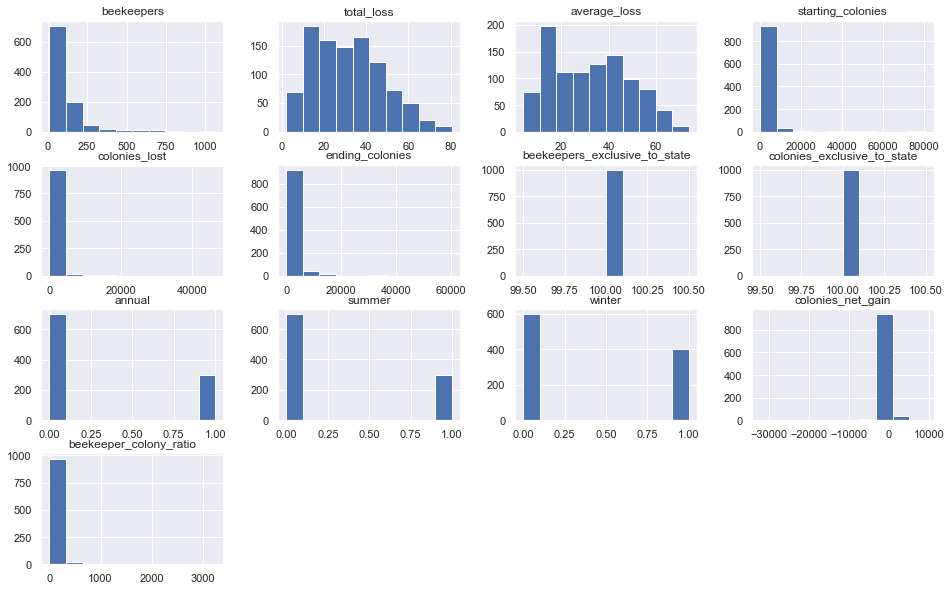

In [10]:
# preliminary univariate exploration histograms
train.hist(figsize=[16,10])
plt.show()

### Does the beekeeper to hive ratio have an effect on colony loss? If so, does a higher beekeeper to hive ratio have less or more loss?

<Figure size 1152x648 with 0 Axes>

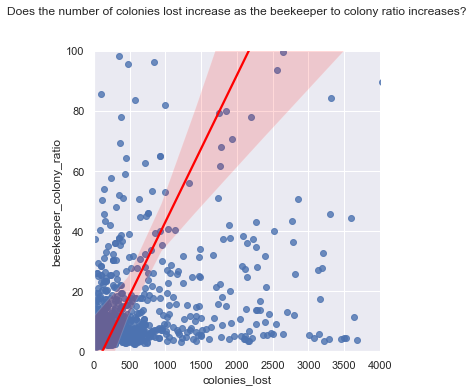

In [8]:
# relationship between total_loss and beekeepers with regression line
plt.figure(figsize=[16,9])
#use lmplot
sns.lmplot(x='colonies_lost', y='beekeeper_colony_ratio', data=train, line_kws={'color': 'red'})
#set limit in x axis
plt.xlim([0,4000])
#set limit in y axis
plt.ylim([0,100])
#set title
plt.title('Does the number of colonies lost increase as the beekeeper to colony ratio increases?', y=1.1)
plt.show()

#### Statistical test for correlation between colonies_lost and beekeeper_colony_ratio

H0: There is no relationship between the number of colonies lost annually and the beekeeper to colony ratio.

Ha: There is a relationship between the number of colonies lost annually and the beekeeper to colony ratio.
Stats test: correlation (continuous & continuous)

In [9]:
#run Pearson's Correlation Coefficient test
corr, p = stats.pearsonr(train.beekeeper_colony_ratio, train.colonies_lost)
#set alpha
alpha = .05
if p < alpha:
    print('We reject the null hypothesis.')

else:
    print('We fail to reject the null hypothesis.')

We reject the null hypothesis.


### How many colonies diminished over time? (State/Overall)

In [20]:
annual = train[train.annual == 1]

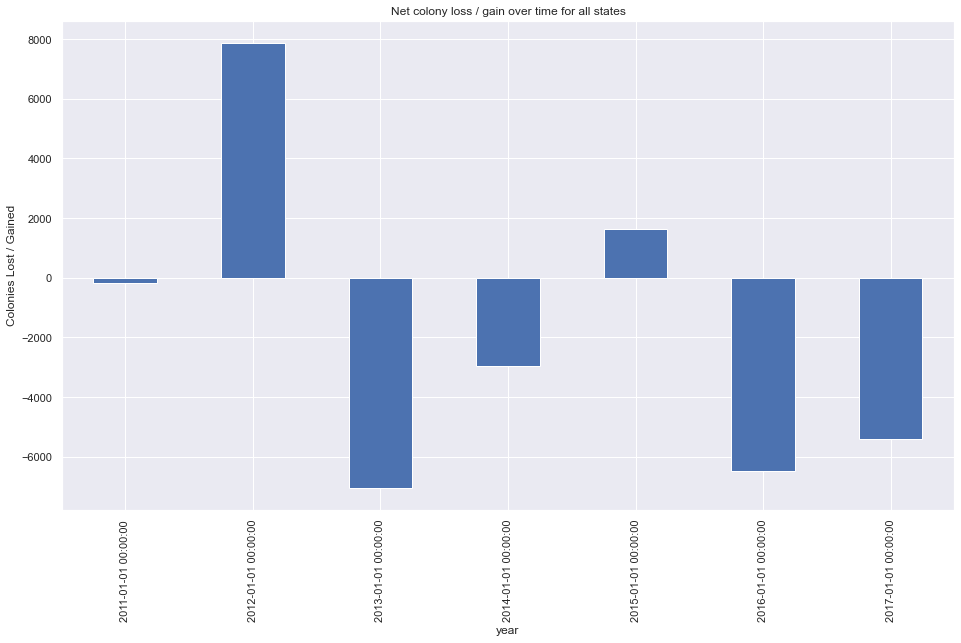

In [29]:
annual.groupby('year').colonies_net_gain.sum().plot.bar(figsize=[16,9], title='Net colony loss / gain over time for all states',
                                                      ylabel='Colonies Lost / Gained')
plt.show()

### Which state suffered the heaviest loss? Which state has the least loss / highest gain?

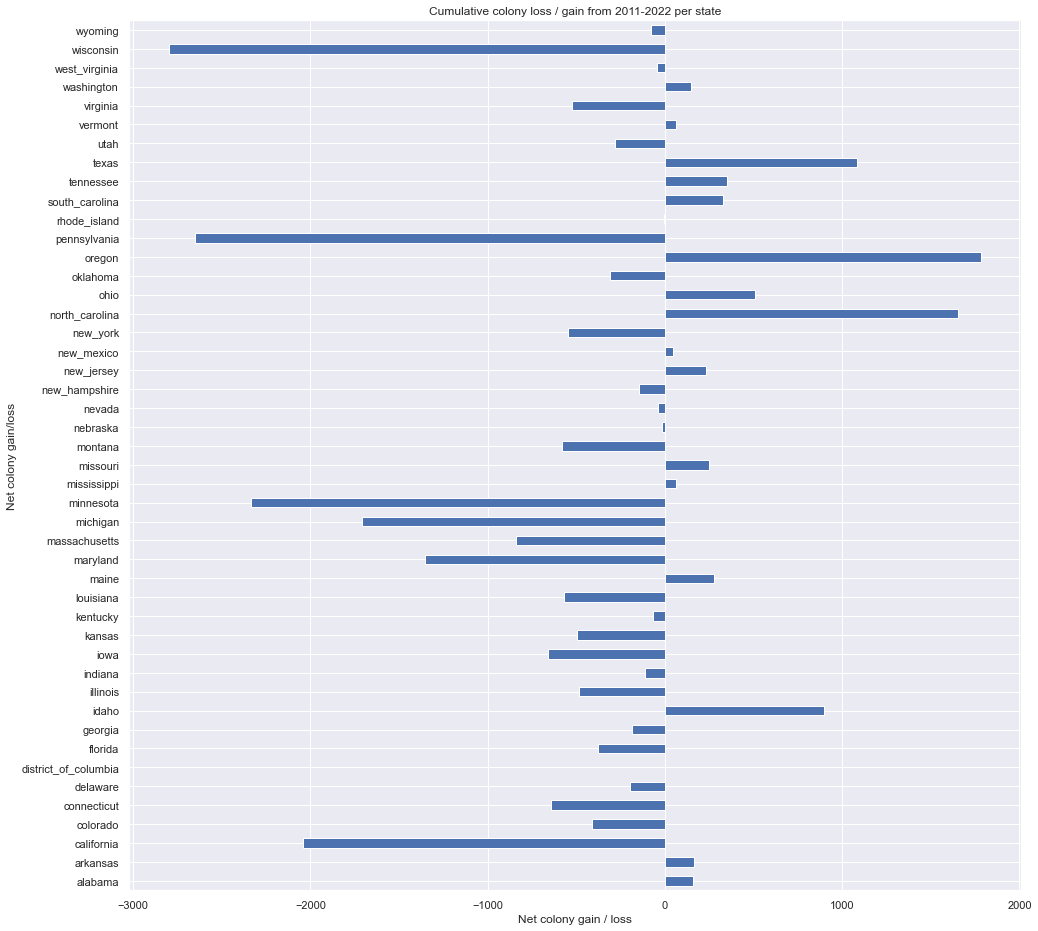

In [33]:
annual.groupby(['state']).colonies_net_gain.sum().plot.barh(figsize=[16,16], title='Cumulative colony loss / gain from 2011-2022 per state',
                                                      xlabel='Net colony gain/loss')
plt.xlabel('Net colony gain / loss')
plt.show()

### Does Winter or Summer have the largest loss?

<Figure size 1152x720 with 0 Axes>

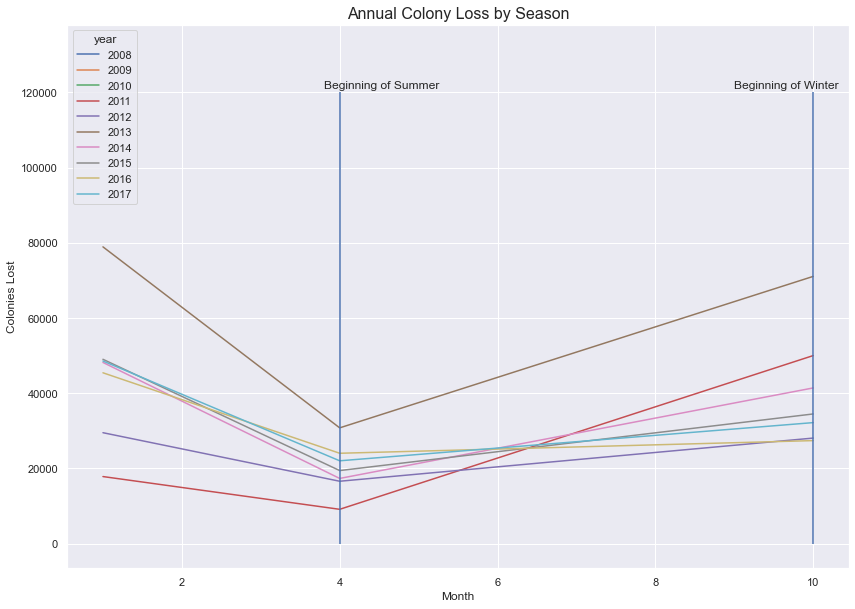

In [34]:
# set figure size
plt.figure(figsize=(16, 10))
# plot colonies lost, grouped by year and month
train.colonies_lost.groupby([train.index.year, train.index.month]).sum().unstack(0).plot(figsize = (14,10))
# set title
plt.title('Annual Colony Loss by Season', fontsize = 16)
# set tick label formatting
plt.ticklabel_format(style='plain', axis='y')
# plot vertical line for summer
plt.vlines(x=4, ymin=0, ymax=120000)
# plot vertical line for winter
plt.vlines(x=10, ymin=0, ymax=120000)
# label vertical line for summer
plt.annotate('Beginning of Summer', [3.8,121000], xycoords='data')
# label vertical line for winter
plt.annotate('Beginning of Winter', [9.0,121000], xycoords='data')
# label x-axis
plt.xlabel('Month')
# label y-axis
plt.ylabel('Colonies Lost')
plt.show()

- More colonies are lost in the winter than in the summer every year.

### Statistical test for significant difference between colonies lost in winter and colonies lost in summer

- H0: There is no difference between the number of colonies lost in the summer and the number of colonies lost in the winter.

- Ha: There is a difference between the number of colonies lost in the summer and the number of colonies lost in the winter.

- Stats test: T-test (categorical & continuous)

In [38]:
alpha = .05
stat, pval = stats.levene(train.colonies_lost[train.season=='summer'], 
                          train.colonies_lost[train.season=='winter'])

In [39]:
if pval < alpha:
    print('We can reject the null hypothesis of equal variances.')
else:
    print('We fail to reject the null hypothesis that variance is equal.')

We can reject the null hypothesis of equal variances.


In [41]:
winter_loss = train.colonies_lost[train.season=='winter']
summer_loss = train.colonies_lost[train.season=='summer']

t, p = stats.ttest_ind(winter_loss, summer_loss, equal_var=False)
t, p

(4.480370368257056, 9.139665556616821e-06)

In [42]:
if (t > 0) and ((p/2) < alpha):
    print('We reject our null hypothesis that there is no difference in colony loss in summer and winter.')
else:
    print('we fail to reject our null hypothesis that there is no difference in colony loss in summer and winter.')

We reject our null hypothesis that there is no difference in colony loss in summer and winter.


### We can reject the null hypothesis that there is no difference in colony loss between summer and winter.

## Modeling

#### Scaling data

Scaling is the process by which we normalize the numeric range of the attributes of our data. 

In [11]:
# numeric columns to be scaled
columns = [col for col in train.drop(columns = ["state","season","colonies_lost"])]

In [12]:
#run scale data function to scale our numeric columns
scaled_train, scaled_validate, scaled_test = model.scale_data(train,validate,test,columns)

#### Feature selection

We are going to apply sklearn's SelectKbest and Recursive feature elimination to help us identify our top 5 features to fit into our model

##### Selectkbest

In [13]:
#Split the data to fit in the model
X= scaled_train[[col for col in scaled_train.columns if col.endswith("scaled")]]
y = scaled_train[["colonies_lost"]]

In [14]:
def select_kbest(X,y,k):
    """This function will input two array X, y and number of top features K and outputs the top k number of features """
    #create the model
    kbest = SelectKBest(f_regression, k=k)
    #fit the model
    kbest.fit(X,y)
    #output the top features 
    features = X.columns[kbest.get_support()]
    
    return features

In [15]:
#run the function
select_kbest(X,y,4)

Index(['starting_colonies_scaled', 'ending_colonies_scaled',
       'colonies_net_gain_scaled', 'beekeeper_colony_ratio_scaled'],
      dtype='object')

    These columns are our top features. Similarly, we can also apply recursive feature selection to help us identify our drivers

##### Recursive feature selection

In [16]:
def select_rfe(X,y,  n_features_to_select = 4):
    """This function will input two array X, y and number of top features desired and outputs those features """
    #create the model
    rfe=RFE(LinearRegression(), n_features_to_select = n_features_to_select) 
    #fit the model
    rfe.fit(X,y)
    #output top features
    features = X.columns[rfe.get_support()]
    
    return features

In [17]:
#run the function
select_rfe(X,y,  n_features_to_select = 4)

Index(['starting_colonies_scaled', 'ending_colonies_scaled',
       'colonies_net_gain_scaled', 'beekeeper_colony_ratio_scaled'],
      dtype='object')

    These featuers are identical to the features we obtain from Selectkbest. Hence we can use them to fit our regression models

In [18]:
#create list of  features to train the regression model with
features = ['starting_colonies_scaled', 'ending_colonies_scaled','colonies_net_gain_scaled', 'beekeeper_colony_ratio_scaled']

In [19]:
# X_train will be subset of our scaled train data with features only
X_train = scaled_train[features]
# set target
y_train = scaled_train[["colonies_lost"]]
# X_validate will be subset of our scaled validate data with features only
X_validate = scaled_validate[features]
# set target
y_validate = scaled_validate[["colonies_lost"]]
# X_test will be subset of our scaled test data with features only
X_test = scaled_test[features]
#set target
y_test = scaled_test[["colonies_lost"]]

#### Baseline
Baseline represents the prediction of the colonies lost with out using features. We will use mean and median of our target from train data and calculate lower baseline RMSE. Our models will then aim to beat this baseline RMSE.

In [20]:
def get_baseline_RMSE(y_train,y_validate):
    '''
    this function will calculate baseline mean and baseline median and calculate RMSE from mean and median
    '''
    #get mean of target from train
    y_train["baseline_mean"] = y_train.colonies_lost.mean()
    #get median of target from train
    y_train["baseline_median"] =y_train.colonies_lost.median()
    #get mean of target from validate
    y_validate["baseline_mean"] = y_validate.colonies_lost.mean()
    #get median from target from validate
    y_validate["baseline_median"] =y_validate.colonies_lost.median()
    
    #calculate RMSE 
    RMSE_train_mean=mean_squared_error(y_train.colonies_lost,y_train.baseline_mean, squared = False)
    RMSE_validate_mean=mean_squared_error(y_validate.colonies_lost,y_validate.baseline_mean, squared = False)

    print("RMSE using Mean on \nTrain: ", round(RMSE_train_mean,2), "\nValidate: ", round(RMSE_validate_mean,2))
    print()

    #calculate RMSE
    RMSE_train_median= mean_squared_error(y_train.colonies_lost,y_train.baseline_median, squared = False)
    RMSE_validate_median= mean_squared_error(y_validate.colonies_lost,y_validate.baseline_median, squared = False)

    print("RMSE using Median on \nTrain: ", round(RMSE_train_median,2), "\nValidate: ", round(RMSE_validate_median,2))

In [21]:
#call in baseline function
get_baseline_RMSE(y_train,y_validate)

RMSE using Mean on 
Train:  2675.28 
Validate:  1881.73

RMSE using Median on 
Train:  2759.24 
Validate:  1911.84


    Since our baseline RMSE using mean is smaller than RMSE using median, we will use RMSE mean for our baseline

We will be using regression models such as Linear regression(OLS), LassoLars, Tweedie regressor and Polynomial features to train our models and predict colonies lost

In [33]:
def RMSE(X_train,y_train, X_validate, y_validate):
    '''
    this function will calculate baseline mean and baseline median and calculate RMSE from mean and median
    '''
    #get mean of target from train
    y_train["baseline_mean"] = y_train.colonies_lost.mean()
    #get median of target from train
    y_train["baseline_median"] =y_train.colonies_lost.median()
    #get mean of target from validate
    y_validate["baseline_mean"] = y_validate.colonies_lost.mean()
    #get median from target from validate
    y_validate["baseline_median"] =y_validate.colonies_lost.median()
    
    #calculate RMSE 
    RMSE_train_mean=mean_squared_error(y_train.colonies_lost,y_train.baseline_mean, squared = False)
    RMSE_validate_mean=mean_squared_error(y_validate.colonies_lost,y_validate.baseline_mean, squared = False)

    #print("RMSE using Mean on \nTrain: ", round(RMSE_train_mean,2), "\nValidate: ", round(RMSE_validate_mean,2))
    #print()

    #calculate RMSE
    RMSE_train_median= mean_squared_error(y_train.colonies_lost,y_train.baseline_median, squared = False)
    RMSE_validate_median= mean_squared_error(y_validate.colonies_lost,y_validate.baseline_median, squared = False)

    #print("RMSE using Median on \nTrain: ", round(RMSE_train_median,2), "\nValidate: ", round(RMSE_validate_median,2))
    
    #make a dataframe to capture model and RMSE 
    metric_df = pd.DataFrame(data=[
            {
                'model': 'Baseline', 
                'RMSE_train': RMSE_train_mean,
                'RMSE_validate': RMSE_validate_mean
                }
            ])
    
   
    
    # create the model object
    lm = LinearRegression(normalize = True)
    # Fit the model
    lm.fit(X_train, y_train.colonies_lost)
    # Predict y on train
    y_train['colonies_lost_pred_lm'] = lm.predict(X_train)
    # predict validate
    y_validate['colonies_lost_pred_lm'] = lm.predict(X_validate)
    
    # evaluate: train rmse
    rmse_train_lm= round(mean_squared_error(y_train.colonies_lost, y_train.colonies_lost_pred_lm,squared = False), 2)
    # evaluate: validate rmse
    rmse_validate_lm= round(mean_squared_error(y_validate.colonies_lost, y_validate.colonies_lost_pred_lm,squared = False),2)

    #append model and RMSE from OLS model to metric dataframe
    metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_train': rmse_train_lm,
    'RMSE_validate': rmse_validate_lm,
    }, ignore_index=True)
    
    
    # create the model object
    lars = LassoLars(alpha=1, random_state = 825)
    # fit the model.
    lars.fit(X_train, y_train.colonies_lost)
    # predict train
    y_train['colonies_lost_pred_lars'] = lars.predict(X_train)
    # predict validate
    y_validate['colonies_lost_pred_lars'] = lars.predict(X_validate)
    # evaluate: train rmse
    rmse_train_lars = round(mean_squared_error(y_train.colonies_lost, y_train.colonies_lost_pred_lars, squared = False),2)
    # evaluate: validate rmse
    rmse_validate_lars= round(mean_squared_error(y_validate.colonies_lost, y_validate.colonies_lost_pred_lars,squared = False),2)

    #append model and RMSE from LASSOLARS model to metric dataframe
    metric_df = metric_df.append({
    'model': 'LASSOLARS(alpha = 1)', 
    'RMSE_train': rmse_train_lars,
    'RMSE_validate': rmse_validate_lars,
    }, ignore_index=True)
    
    
    
    # create the model object
    glm = TweedieRegressor(power=1, alpha=0)
    # fit the model to our training data.
    glm.fit(X_train, y_train.colonies_lost)
    # predict train
    y_train['colonies_lost_pred_glm'] = glm.predict(X_train)
    # predict validate
    y_validate['colonies_lost_pred_glm'] = glm.predict(X_validate)
    # evaluate: train rmse
    rmse_train_tw = round(mean_squared_error(y_train.colonies_lost, y_train.colonies_lost_pred_glm,squared = False),2)
    # evaluate: validate rmse
    rmse_validate_tw= round(mean_squared_error(y_validate.colonies_lost, y_validate.colonies_lost_pred_glm, squared = False),2)

    #append model and RMSE from GLM model to metric dataframe
    metric_df = metric_df.append({
    'model': 'Tweedie Regressor(power=1, alpha=0)', 
    'RMSE_train': rmse_train_tw,
    'RMSE_validate': rmse_validate_tw,
    }, ignore_index=True)
    
    
    
    
    #create model object
    pf= PolynomialFeatures(degree= 2)
    # fit and transform X_train_scaled
    X_train_degree2 = pf.fit_transform(X_train)
    # transform X_validate_scaled 
    X_validate_degree2 = pf.transform(X_validate)

    # create the model object
    lm2 = LinearRegression(normalize=True)
    # fit the model to our training data. We must specify the column in y_train,  
    lm2.fit(X_train_degree2, y_train.colonies_lost)
    # predict train
    y_train['colonies_lost_pred_lm2'] = lm2.predict(X_train_degree2)
    # predict validate
    y_validate['colonies_lost_pred_lm2'] = lm2.predict(X_validate_degree2)

    # evaluate: train rmse
    rmse_train_py= round(mean_squared_error(y_train.colonies_lost, y_train.colonies_lost_pred_lm2, squared = False),2)
    # evaluate: validate rmse
    rmse_validate_py= round(mean_squared_error(y_validate.colonies_lost, y_validate.colonies_lost_pred_lm2, squared = False) , 2)

    #append model and RMSE from Polynomial Regression model to metric dataframe
    metric_df = metric_df.append({
    'model': 'Polynomial Regression(degree = 2)', 
    'RMSE_train': rmse_train_py,
    'RMSE_validate': rmse_validate_py,
    }, ignore_index=True)
    
    
    print(metric_df)

In [34]:
# call in function to calculate RMSE on our models
RMSE(X_train,y_train, X_validate, y_validate)

                                 model   RMSE_train  RMSE_validate
0                             Baseline  2675.278862    1881.731008
1                        OLS Regressor  1089.660000     882.270000
2                 LASSOLARS(alpha = 1)  1089.180000     897.700000
3  Tweedie Regressor(power=1, alpha=0)  1674.010000    1950.430000
4    Polynomial Regression(degree = 2)  1018.150000    1281.370000


    Our best model OLS regressor with RMSE of 1089.
    It beats baseline by 59 %
    We will use this model in our unseen data
    

Using OLS regressor into Test data

In [35]:
# create the model object
def test_rmse(X_train,y_train,X_test,y_test):
    lm = LinearRegression(normalize = True)
    # Fit the model
    lm.fit(X_train, y_train.colonies_lost)
    # Predict y on train
    y_train['colonies_lost_pred_lm2'] = lm.predict(X_train)
      # predict y on test
    y_test['colonies_lost_pred_lm'] = lm.predict(X_test)
    

    # evaluate: test rmse
    rmse_test= round(mean_squared_error(y_test.colonies_lost, y_test.colonies_lost_pred_lm,squared = False),2)
    rmse_baseline = round(mean_squared_error(y_train.colonies_lost,y_train.baseline_mean, squared = False),2)

    print(f'The RMSE on test dataset is {rmse_test} while RMSE on baseline is {rmse_baseline}.' )
    

In [36]:
test_rmse(X_train,y_train,X_test,y_test)

The RMSE on test dataset is 1731.07 while RMSE on baseline is 2675.28.


Let us see how our models performed

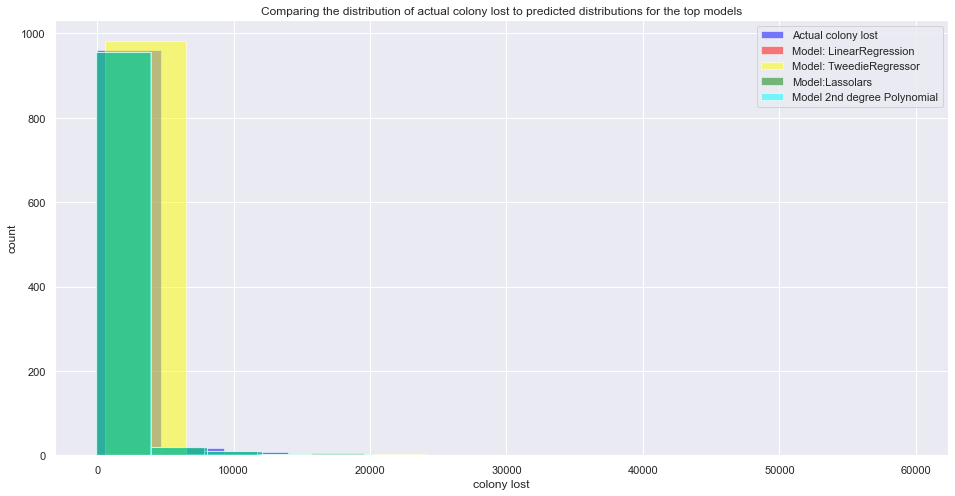

In [26]:
explore.model_performace(y_train)

### Conclusion:

We were able to produce a model that beats the baseline and predict colony loss